### **DISLEX.AI**

### **GENERACION DE LA INFORMACION**

Haz un clone del repositorio, si ya lo tenias haz un Pull para descargar las actualizaciones del repo:

In [ ]:
from getpass import getpass
import os

# Solicitar el token de GitHub
token = "****************"

In [ ]:
#Hacer Pull del repositorio
!git pull https://{token}@github.com/pablopayagascon/Dislex.ia.git


fatal: not a git repository (or any of the parent directories): .git


In [ ]:
# Clonar el repositorio privado usando el token
!git clone https://{token}@github.com/pablopayagascon/Dislex.ia.git

# Cambiar al directorio del repositorio
os.chdir('/content/Dislex.ia')



fatal: destination path 'Dislex.ia' already exists and is not an empty directory.


In [ ]:
# # Instalar las dependencias
!pip install -r requirements.txt

In [ ]:
from PIL import Image
import os
from textblob import TextBlob
import language_tool_python
import requests
import pandas as pd
import random
import speech_recognition as sr
import pyttsx3
import time
import eng_to_ipa as ipa
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import csv

In [ ]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            # j+1 instead of j since previous_row and current_row are one character longer
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

In [ ]:
# image to text API authentication
subscription_key_imagetotext = "*****"
endpoint_imagetotext = "https://dislexia.cognitiveservices.azure.com/"
computervision_client = ComputerVisionClient(
    endpoint_imagetotext, CognitiveServicesCredentials(subscription_key_imagetotext))

# '''-------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

# text correction API authentication
api_key_textcorrection = "*****"
endpoint_textcorrection = "https://api.bing.microsoft.com/v7.0/SpellCheck"

# '''-------------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

my_tool = language_tool_python.LanguageTool('en-US')


INFO:language_tool_python.download_lt:Unzipping /tmp/tmp8a_d6pls.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-5.7.zip to /root/.cache/language_tool_python.


In [ ]:
 # method for extracting the text

def image_to_text(path):
    read_image = open(path, "rb")
    read_response = computervision_client.read_in_stream(read_image, raw=True)
    read_operation_location = read_response.headers["Operation-Location"]
    operation_id = read_operation_location.split("/")[-1]

    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status.lower() not in ['notstarted', 'running']:
            break
        time.sleep(5)

    text = []
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                text.append(line.text)

    return " ".join(text)

In [ ]:
# method for finding the spelling accuracy

def spelling_accuracy(extracted_text):
    spell_corrected = TextBlob(extracted_text).correct()
    return ((len(extracted_text) - (levenshtein(extracted_text, spell_corrected)))/(len(extracted_text)+1))*100

In [ ]:
# method for gramatical accuracy

def gramatical_accuracy(extracted_text):
    spell_corrected = TextBlob(extracted_text).correct()
    correct_text = my_tool.correct(spell_corrected)
    extracted_text_set = set(spell_corrected.split(" "))
    correct_text_set = set(correct_text.split(" "))
    n = max(len(extracted_text_set - correct_text_set),
            len(correct_text_set - extracted_text_set))
    return ((len(spell_corrected) - n)/(len(spell_corrected)+1))*100

In [ ]:
# percentage of corrections

def percentage_of_corrections(extracted_text):
    data = {'text': extracted_text}
    params = {
        'mkt': 'en-us',
        'mode': 'proof'
    }
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Ocp-Apim-Subscription-Key': api_key_textcorrection,
    }
    response = requests.post(endpoint_textcorrection,
                             headers=headers, params=params, data=data)
    json_response = response.json()

    # Verificar si 'flaggedTokens' está en la respuesta
    if 'flaggedTokens' in json_response:
        return len(json_response['flaggedTokens']) / len(extracted_text.split(" ")) * 100
    else:
        # Manejar el caso donde 'flaggedTokens' no está presente
        print("Error: 'flaggedTokens' no está en la respuesta")
        return None



In [ ]:
def get_feature_array(path: str):
    feature_array = []
    extracted_text = image_to_text(path)
    feature_array.append(spelling_accuracy(extracted_text))
    feature_array.append(gramatical_accuracy(extracted_text))
    feature_array.append(percentage_of_corrections(extracted_text))
    return feature_array

In [ ]:
def generate_csv(folder: str, label: int, csv_name: str):
    arr = []
    for image in os.listdir(folder):
        path = os.path.join(folder, image)
        feature_array = get_feature_array(path)
        feature_array.append(label)
        # print(feature_array)
        arr.append(feature_array)
        print(feature_array)
    print(arr)
    pd.DataFrame(arr, columns=["spelling_accuracy", "gramatical_accuracy", " percentage_of_corrections", "presence_of_dyslexia"]).to_csv("test1.csv")

### **PREDICCION DE DISLEXIA USANDO REGRESION LOGISTICA**

In [ ]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sb

train_data = pd.read_csv("/content/Dislex.ia/model_training/train.csv")
# train_data.head()

test_data = pd.read_csv("/content/Dislex.ia/model_training/test.csv")
# test_data.head()


In [ ]:
x_train = np.array(train_data.drop(['presence_of_dyslexia'], axis="columns"))
y_train = np.array(train_data['presence_of_dyslexia'])

x_test= np.array(test_data.drop(['presence_of_dyslexia'], axis="columns"))
y_test = np.array(test_data['presence_of_dyslexia'])

In [ ]:
model_logistic = linear_model.LogisticRegression()
model_logistic.fit(x_train,y_train)

LogisticRegression()

<Axes: >

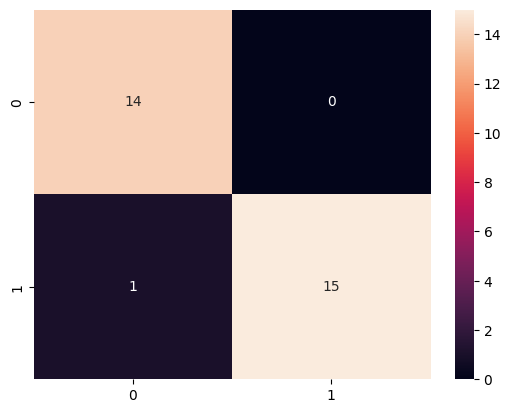

In [ ]:
# Heatmap to check relationships between variables
sb.heatmap(confusion_matrix(model_logistic.predict(x_test), y_test), annot=True)

### **MAIN**

In [ ]:
if __name__ == "__main__":

    img = "/content/10.jpg"
    result = list()

    # create dataframe
    extracted_text = image_to_text(img)
    spl_accuracy = spelling_accuracy(extracted_text)
    result.append(spl_accuracy)
    grm_accuracy = gramatical_accuracy(extracted_text)
    result.append(grm_accuracy)
    p_correction = percentage_of_corrections(extracted_text)
    result.append(p_correction)

    # Imprime los resultados
    print(f"Extracted text: {extracted_text}")
    print(f"Spelling accuracy: {spl_accuracy}")
    print(f"Gramatical_accuracy: {grm_accuracy}")
    print(f"Percentage of corrections: {p_correction}")

    print(result)

Extracted text: I have leand that thair are five steps in righting a story. hay are preerighting righting reirsing, editing, and publishing. Preerighting is wen you right down ideyus for the story. Righting is wing you have disided on a objekt and you right it Revising is makeing the story smothe. Editing is checking speling, punshuation and capitalusion. Pudishing is wen you send it to a Publisher to put it out in the market. I also leand some cereksoins marke such as imi; I want to be a good sientes you need to shair it with other sientests.
Spelling accuracy: 95.50561797752809
Gramatical_accuracy: 99.62192816635161
Percentage of corrections: 18.75
[95.50561797752809, 99.62192816635161, 18.75]


In [ ]:
    # Guardar los resultados en un archivo CSV
    with open('resultados.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file, delimiter=',')
        #writer.writerow(['Spelling Accuracy', 'Grammatical Accuracy', 'Percentage of Corrections'])
        writer.writerow(result)

In [ ]:
    # Convierte la lista de resultados a un DataFrame de pandas con columnas correspondientes
    result_df = pd.DataFrame([result], columns=['spelling_accuracy', 'gramatical_accuracy', 'percentage_of_corrections'])

    # Mostrar el DataFrame
    print(result_df)

   spelling_accuracy  gramatical_accuracy  percentage_of_corrections
0          95.505618            99.621928                      18.75


In [ ]:
    data = pd.read_csv("/content/Dislex.ia/data/test-mix-dislexia.csv")
    data = data.drop(columns =  ["Unnamed: 0", "presence_of_dyslexia"])
    data.head(6)
    # print(data)
    # Predice usando el modelo entrenado
    prediction = model_logistic.predict(data)

    # Agregar las predicciones al DataFrame
    data["predictions"] = prediction
    data.to_csv("/content/Dislex.ia/data/predictions.csv", index=False)
    data.head()

    prediction_test = model_logistic.predict(result_df)

    # Imprime las predicciones
    # print(f"Prediction: {prediction}")
    print(f"Prediction probabilities: {prediction_test[0]}")

Prediction probabilities: 1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### **ALGUNAS NOTAS**
1. **Spelling accuracy**: diferencia entre dos frases con la distancia lavenstein (numero minimo de cambios necesarios)
	- Probar ir separando palabra por pablara
	- Probar si es mejor imponer la frase esperada o no


```
def spelling_accuracy(extracted_text):
    spell_corrected = TextBlob(extracted_text).correct()
    return ((len(extracted_text) - (levenshtein(extracted_text, spell_corrected)))/(len(extracted_text)+1))*100
```



2. **Gramatical accuracy**: se extraen la plabras con split, se corrige con TextBlobCorrect. Corrige el texto gramaticalmente con MyTool (LangugeTool). Compar la lista de palabras con la primera.


```
def gramatical_accuracy(extracted_text):
    spell_corrected = TextBlob(extracted_text).correct()
    correct_text = my_tool.correct(spell_corrected)
    extracted_text_set = set(spell_corrected.split(" "))
    correct_text_set = set(correct_text.split(" "))
    n = max(len(extracted_text_set - correct_text_set),
            len(correct_text_set - extracted_text_set))
    return ((len(spell_corrected) - n)/(len(spell_corrected)+1))*100
```


3. **Porcentaje de correcciones**: con Azure

# Refencias
[1] P. J. Grother, “NIST Special Database 19,” NIST, 2016. [Online]. Available: https://www.nist.gov/srd/nist-special-database-19. [Accessed: 01-Jun-2024].